# Solar Orbiter Meeting Oct 23 - 25, 2023

# SPICE data analysis tutorial talk
## Tania Varesano, CU Boulder / SWRI 
tania.varesano@colorado.edu

## Here is the link to access the notebook and files

https://drive.google.com/drive/folders/1PE-g3S2x1UoAeWiKzyECk2Ub-TcPLhoQ?usp=share_link

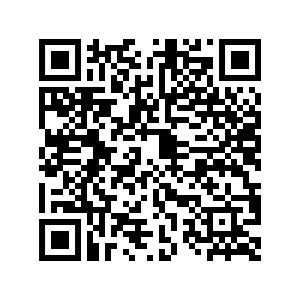

## But what is SPICE on Solar Orbiter ?

<div>
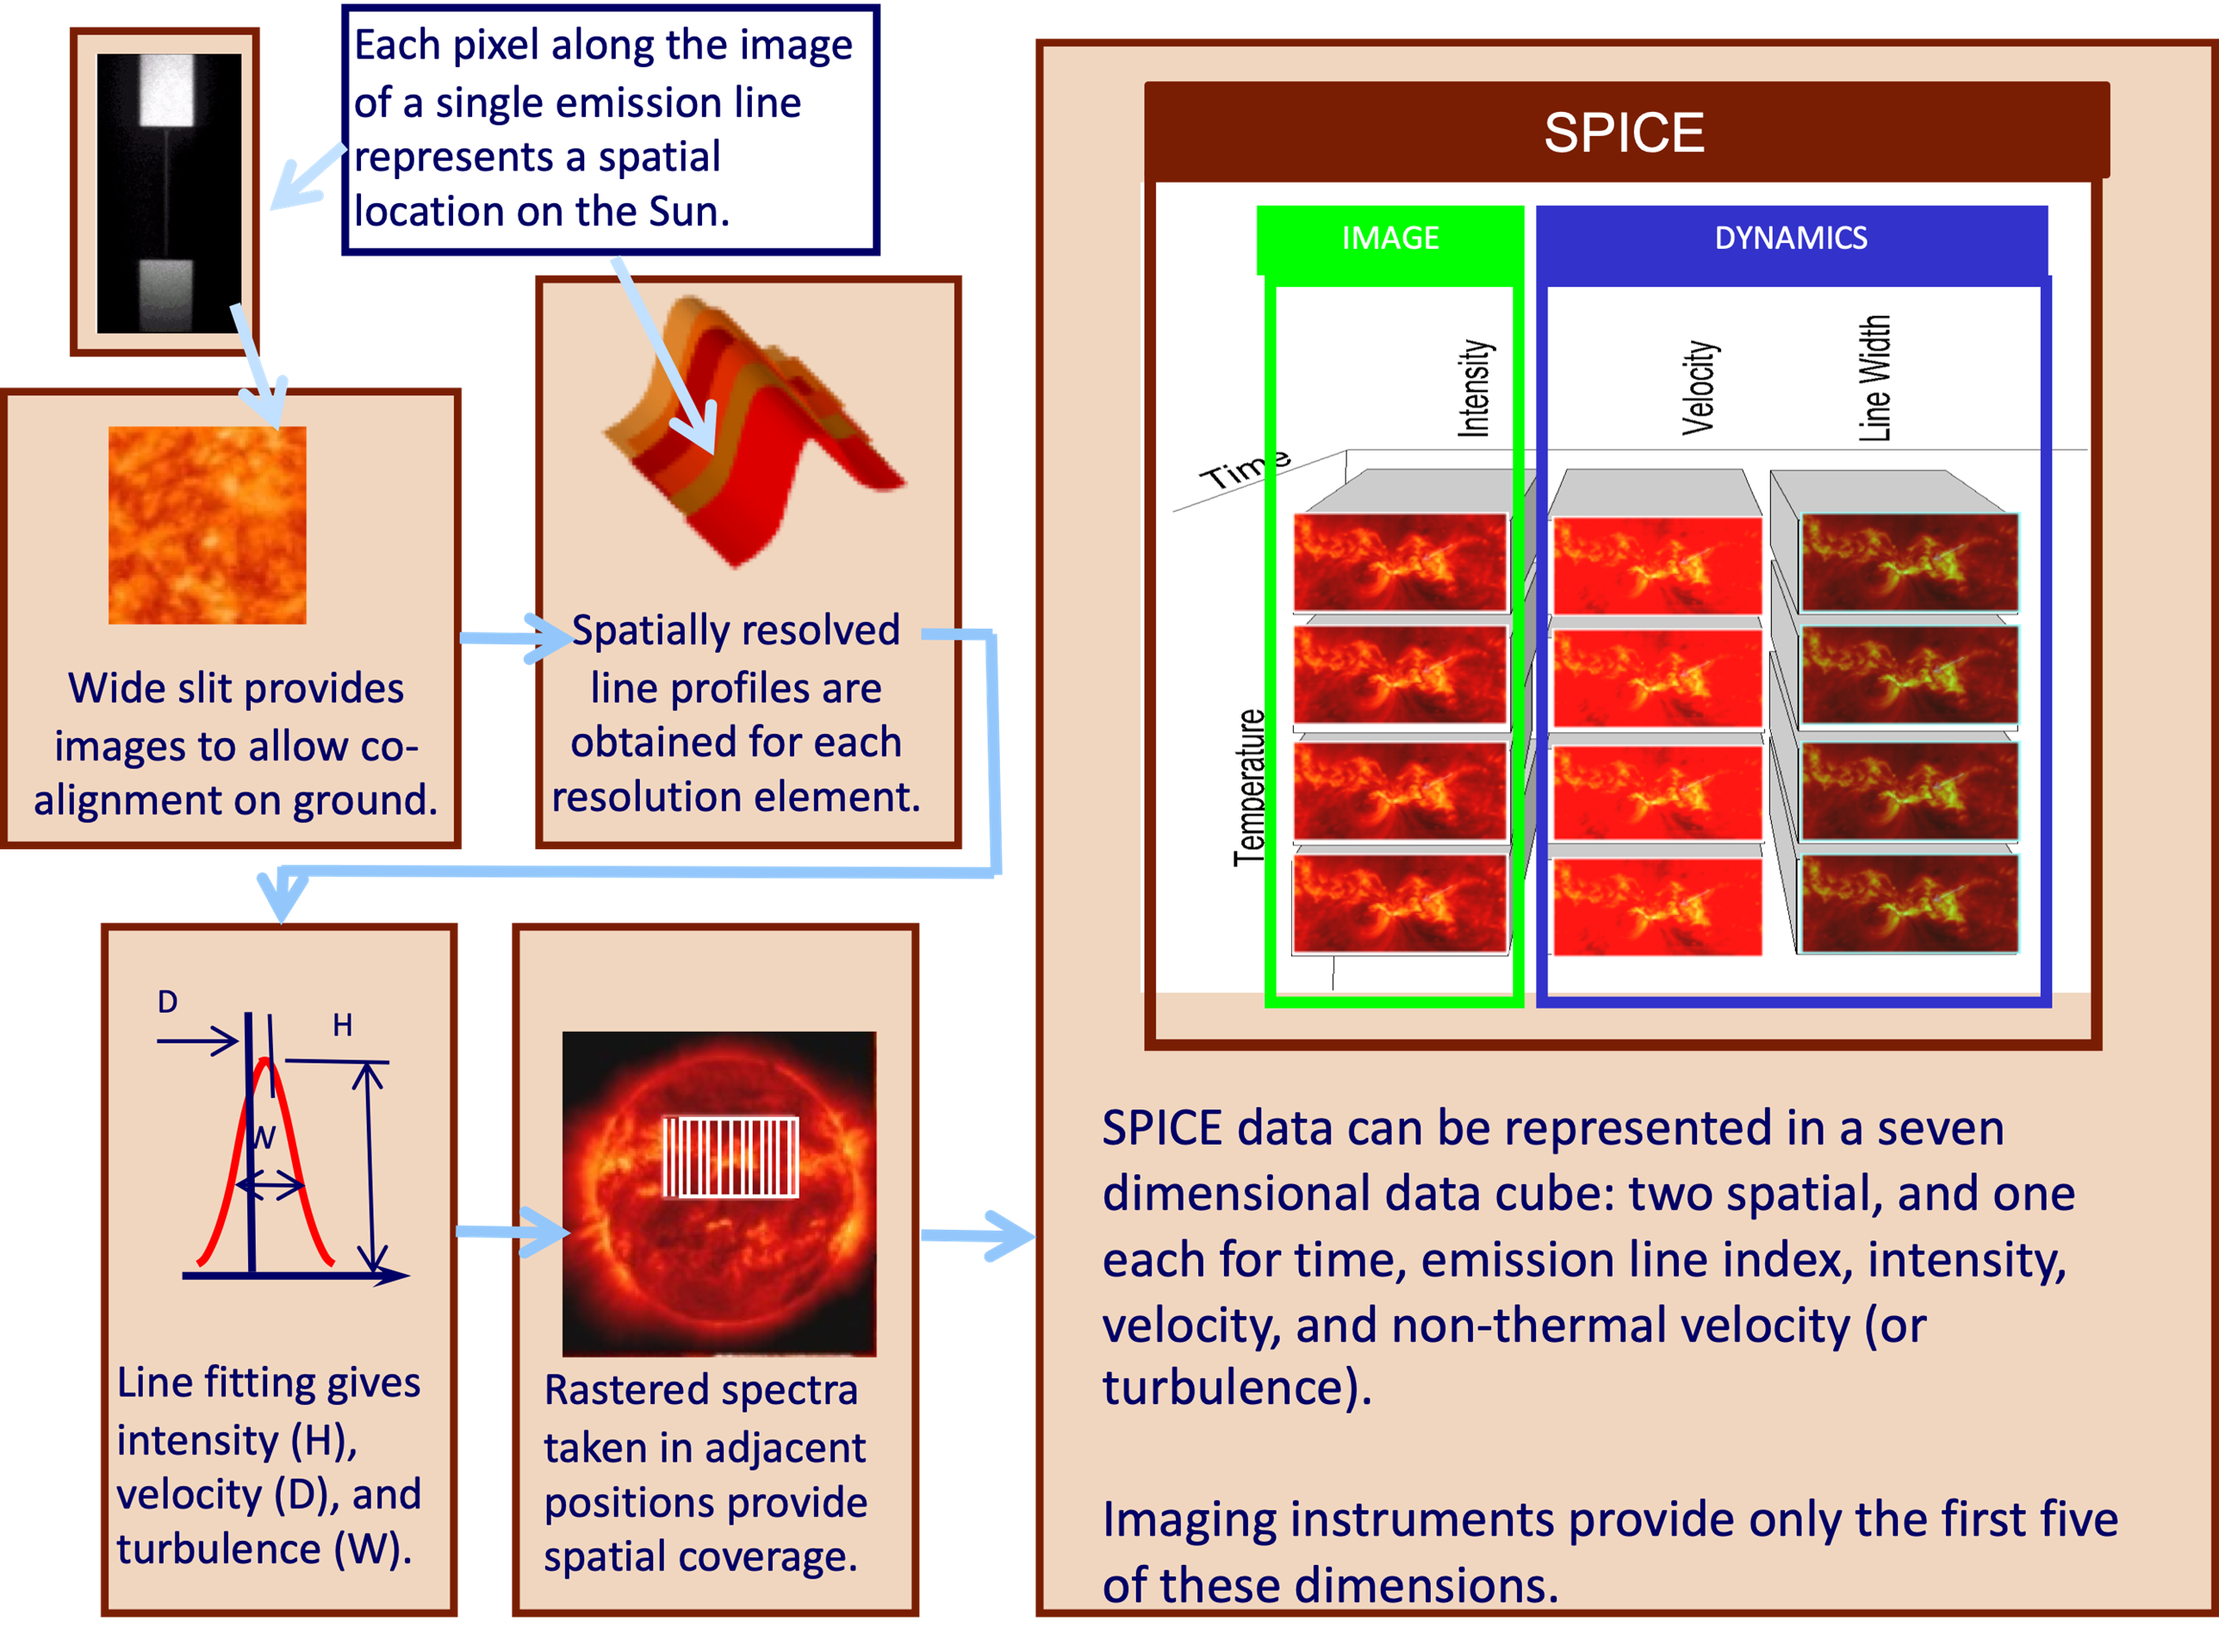
</div>

# Example of a raster 

* 2D at first sight, but contains much more!
* Each file (n-ras) contains several data cubes, all with the same spatial information but at different wavelengths

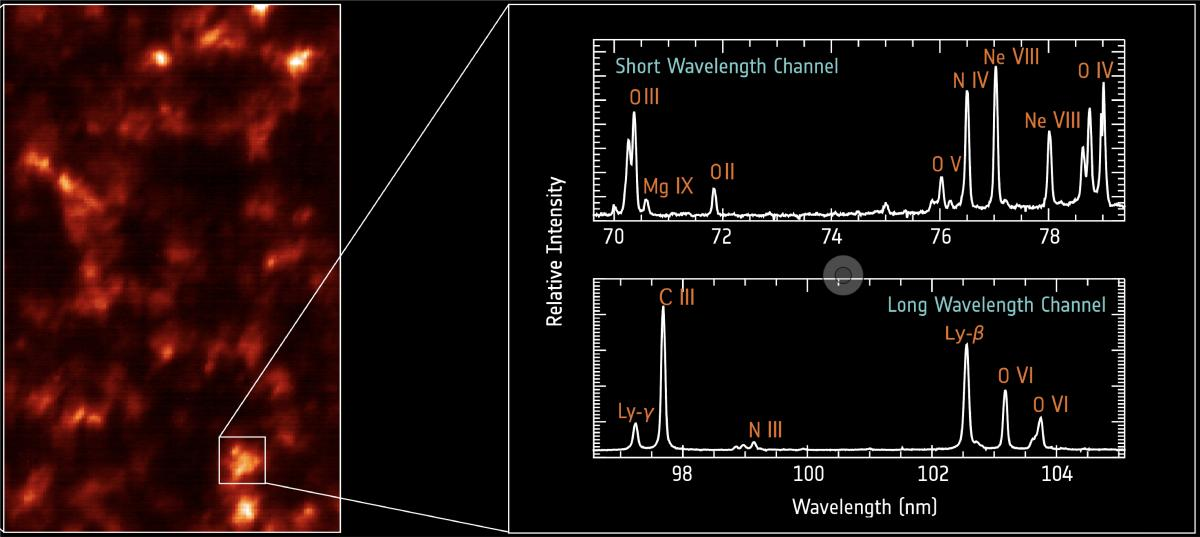

In [1]:
# Import some necessary packages 

import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import os
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
import pickle
import matplotlib.image as mpimg

In [2]:
# Get a file (or files!) from the solar orbiter archive
import sunpy_soar
from sunpy.net import Fido

from sunpy.net.attrs import Instrument, Level, Time
import sunpy.net.attrs as a

# Create search attributes
instrument = Instrument('SPICE')
time = Time('2022-08-22', '2022-08-23')
level = Level(2)
# n-ras: a raster scan with one of the narrow slits (2", 4" or 6")
product = a.soar.Product('spice-n-ras')
# Do search
result = Fido.search(instrument, time, level, product)
print(result)

Results from 1 Provider:

1 Results from the SOARClient:

Instrument Data product Level ...         End time        Filesize
                              ...                          Mbyte  
---------- ------------ ----- ... ----------------------- --------
     SPICE  spice-n-ras    L2 ... 2022-08-22 06:48:19.527  188.654




In [125]:
# Download the first file and print the location of the downloaded file
file = Fido.fetch(result[0][0])
print(file)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['C:\\Users\\tania\\sunpy\\data\\solo_L2_spice-n-ras_20220822T033521_V04_134218246-000.fits']


In [3]:
file = 'C:\\Users\\tania\\sunpy\\data\\solo_L2_spice-n-ras_20220822T033521_V04_134218246-000.fits'

In [65]:
from IPython.display import Video

## For some context...
Credits: Jhelioviewer

In [66]:
Video("images/20220302_1024_0171.mp4")

# Open the file!

In [4]:
exposure = read_spice_l2_fits(file, memmap=False)

#What lines do we have?
keys=list(exposure.keys())
print(keys)

# Get the info for one line
print('\n\nData for window Ne VIII 770 :\n',exposure['Ne VIII 770 (Merged)'])

# for more complete diagnostic, open file with astropy.fits :
#hdulist = fits.open(file[0])
#hdulist.info()
#hdulist[0].header

['O III 703 / Mg IX 706 (Merged)', 'O II 718 - Peak (spectral bin 2)', 'S IV 750/ Mg IX (spectral bin 2)', 'Ne VIII 770 (Merged)', 'S V 786 / O IV 787 (Merged)', 'Ly-gamma-CIII group (Merged)', 'N III 991 (Merged)', 'O VI 1032 (Merged)']


Data for window Ne VIII 770 :
 SpectrogramCube
---------------
Time Period: ['2022-08-22 03:35:51.911' '2022-08-22 06:47:49.212']
Instrument axes: ['raster scan' 'spectral' 'slit' 'slit step']
Pixel dimensions: [  1  40 834 192] pix
Longitude range: [-558.41528544  262.61269535] arcsec
Latitude range: [-543.50522362  418.19439476] arcsec
Spectral range: [7.66710207e-08 7.74316533e-08] m
Data unit: adu


In [5]:
#Take a quick look at the data
raster = exposure[keys[3]]  #take a look at the Ne VIII 770
print('Shape of the raster (spectral, latitude, longitude) : ',raster[0,:,:,:].data.shape)

Shape of the raster (spectral, latitude, longitude) :  (40, 834, 192)


### Plot the Ne VIII 770 A raster

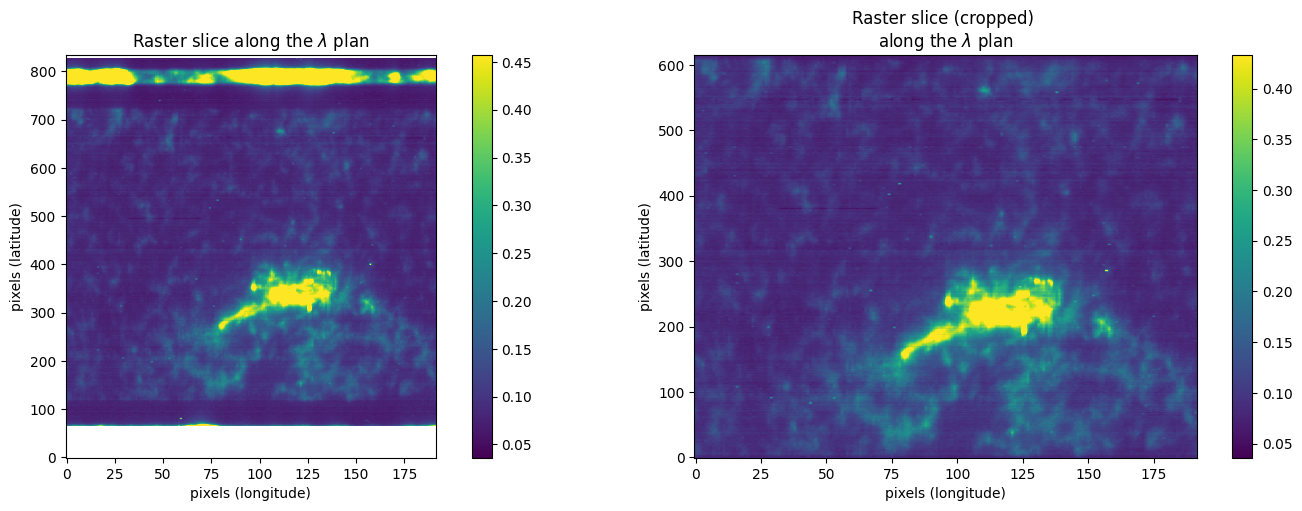

In [6]:
plt.figure(figsize= [15,5], tight_layout=True)
plt.subplot(1,2,1)

#take a spectral slice
plt.imshow(raster[0,15,:,:].data, vmax=np.nanquantile(raster[0,19,:,:].data, 0.9), aspect=1/4)
plt.colorbar(), plt.xlabel('pixels (longitude)'), plt.ylabel('pixels (latitude)')
plt.title('Raster slice along the $\lambda$ plan')

#Crop the edges!
plt.subplot(1,2,2)
plt.imshow(raster[0,15,115:730,:].data, vmax=np.nanquantile(raster[0,19,110:750,:].data, 0.9), aspect=1/4)
plt.colorbar(), plt.xlabel('pixels (longitude)'), plt.ylabel('pixels (latitude)')
plt.title('Raster slice (cropped) \nalong the $\lambda$ plan')
plt.show()

### Let's define a new variable for the "clean" data cube and convert to mW/sr/m2/A
We need to crop the raster and remove the minimum at each pixel along the scan dimension to further correct for dark offset errors.

In [7]:
#spatial binning: saves time and increases SNR
def bindown(d,n):
    inds = np.ravel_multi_index(np.floor((np.indices(d.shape).T*n/np.array(d.shape))).T.astype(np.uint32),n)
    return np.bincount(inds.flatten(),weights=d.flatten(),minlength=np.prod(n)).reshape(n) 

#Define a function to subtract the background noise
def subtract_min_cube(cube):
    cube = np.nan_to_num(cube)
    det_plane_min = np.nanmin(cube,axis=2)
    for i in range(0,cube.shape[2]): 
        cube[:,:,i] -= det_plane_min
    return cube

In [8]:
data_cube = (raster[0,:,115:730,:].data*(u.W/u.m**2/u.sr/u.nm)).to(u.mW/u.m**2/u.sr/u.Angstrom)
print(data_cube.shape)
data_cube = subtract_min_cube(data_cube)

(40, 615, 192)


### How about... 1 pixel?

In [9]:
# Get the wavelengths over which the window has been recorded
wavelengths = raster.spectral_axis.to(u.Angstrom)
wavelengths[19]

<SpectralCoord 
   (target: <Helioprojective Coordinate (obstime=2022-08-22T03:35:21.911, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-08-22T03:35:21.911, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
                (145.70524346, -2.29974772, 1.24513121e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, kpc)
                (-147.90103393, -62.65550562, 1000.)
             (d_Tx, d_Ty, d_distance) in (arcsec / s, arcsec / s, km / s)
                (0., 0., 0.)>)
  770.415853 Angstrom>

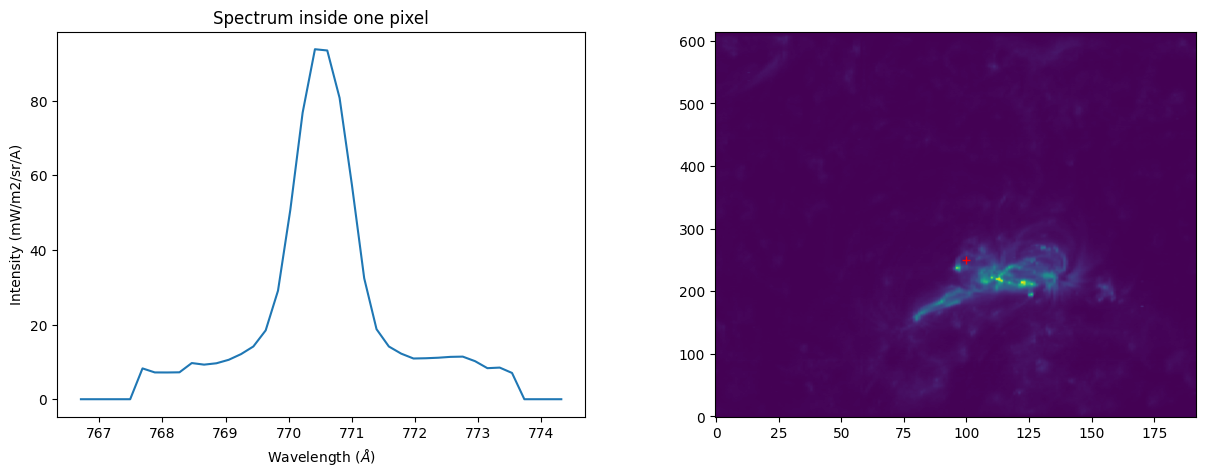

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wavelengths, data_cube[:,250,100].value)
plt.xlabel('Wavelength ($\AA$)'), plt.ylabel('Intensity (mW/m2/sr/A)'), plt.title('Spectrum inside one pixel'), 
plt.subplot(1,2,2)
plt.imshow(data_cube[19,:,:].value, aspect=1/4), plt.plot(100,250,'r+'), plt.show();

# Correct the PSF (new!)
## Courtesy of Joseph Plowman, 2023 (SWRI)
https://www.aanda.org/articles/aa/pdf/2023/10/aa45582-22.pdf

In [ ]:
'''
os.chdir('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\spice_psf_package_nodata\\spice_psf_package_nodata')
from spice_psf_package_nodata.spice_psf_package_nodata.sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster
spice_hdr = raster.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.0

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -13*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([5.5, 1.15])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([20.0, 4]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.21

spice_dat1 = data_cube.value.transpose([2,1,0]).astype(np.float32)
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight, 
                                                                  super_fac=1, psf_thold_core=0.0005)
'''

In [ ]:
#with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\rasterNeVIII_psfcorrected.json', 'wb') as fc:
#    pickle.dump(spice_corr_dat.transpose([2,1,0]), fc)

In [31]:
#load the corrected PSF raster
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\rasterNeVIII_psfcorrected.json', 'rb') as fi:
    data_cube_corr = pickle.load(fi)

# Look at the same spectrum, but with PSF correction
 * the emission line is much sharper!
 * flux is preserved 

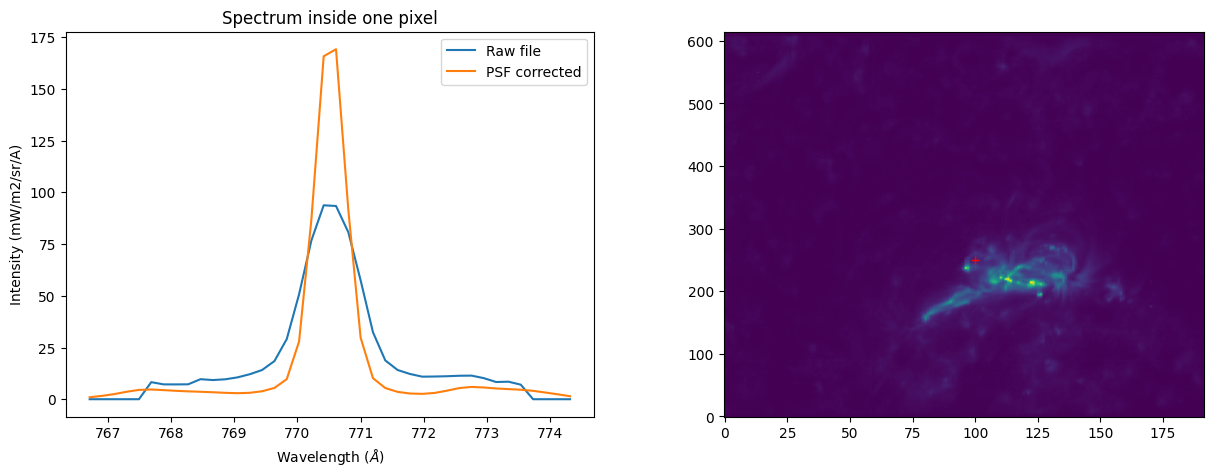

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wavelengths, subbed[:,250,100], label='Raw file')
plt.plot(wavelengths, data_cube_corr[:,250,100], label='PSF corrected')
plt.xlabel('Wavelength ($\AA$)'), plt.ylabel('Intensity (mW/m2/sr/A)'), plt.title('Spectrum inside one pixel'), plt.legend()
plt.subplot(1,2,2)
plt.imshow(data_cube[19,:,:].value, aspect=1/4), plt.plot(100,250,'r+'),plt.show();

## Plot with WCS (World Coordinate System) coordinates
* Map the pixels in an image onto the celestial sphere

In [20]:
raster.meta.original_header

XTENSION= 'IMAGE   '           / Written by IDL:  Wed Jan 18 18:12:31 2023      
BITPIX  =                  -32 / Real*4 (floating point)                        
NAXIS   =                    4 / Number of dimensions                           
NAXIS1  =                  192 / Number of slit positions (x)                   
NAXIS2  =                  834 / Number of pixels along slit (y)                
NAXIS3  =                   40 / Number of pixels in dispersion dimension       
NAXIS4  =                    1 / Number of exposures per slit position (time)   
PCOUNT  =                    0 /  number of random group parameters             
GCOUNT  =                    1 /  number of random groups                       
DATE    = '2023-01-18T18:12:31' / Date and time of FITS file creation           
                                                                                
EXTNAME = 'Ne VIII 770 (Merged)' / Extension name                               
FILENAME= 'solo_L2_spice-n-r

In [21]:
raster.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'TIME'  
CRVAL : -0.041083620536666664  -0.01740430711763889  7.705133700000001e-08  5788.65029144  
CRPIX : 96.5  417.5  20.5  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 0.997945545148  0.0175866237859  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : -0.233398346866  0.997945545148  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : -60.3000030518  0.0  0.0  1.0  
CDELT : 0.0011111111111111111  0.00030500000000000004  1.9503400000000002e-11  1.0  
NAXIS : 192  834  40  1

# And plot with coordinate axes!

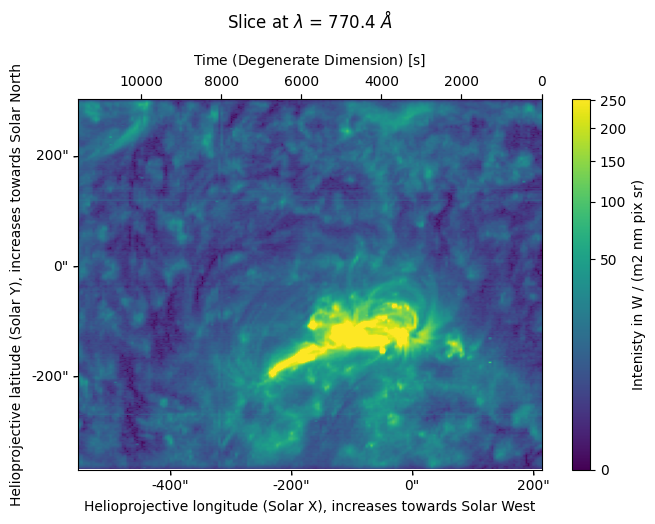

In [34]:
from astropy.wcs import WCS
wcs = WCS(raster.meta.original_header)

# Cropped the file, so we have to crop also the WCS file!
wcs = wcs[0,:,115:730,:]
plt.figure(figsize=(7,5), tight_layout=True)
plt.subplot(111, projection=wcs, slices = ('x', 'y', 19))
plt.imshow((data_cube[19,:,:].data), cmap='viridis',
           norm=mlt.colors.PowerNorm(0.35, vmin=0, vmax=np.nanquantile(data_cube[19,:,:].data, 0.99)), aspect = 1/4)
cbar = plt.colorbar()
cbar.set_label('Intenisty in W / (m2 nm pix sr)')
plt.title('Slice at $\lambda$ = 770.4 $\AA$\n\n\n')
plt.show()

# Computing uncertainties
### Eric Buchlin / SPICE consortium -- sospice (available with pip version)
* `av_constant_noise_level` contains the sum of dark current and background signal levels
* `sigma` contains a dictionary for the standard deviations of:
    * `Dark`: noise on dark current (Poissonian)
    * `Background`: noise on background signal (Poissonian)
    * `Read`: read noise (Gaussian)
    * `Line`: shot noise for the signal (Poissonian)
    * `Total`: the root-sum-square of all noise components. 

In [35]:
from spice_uncertainties import spice_error
from astropy.io import fits
# https://git.ias.u-psud.fr/spice/spice_uncertainties/-/tree/main
with fits.open(file) as hdulist:  # specify file name here
    hdu = hdulist[3];               # specify HDU index here
    av_constant_noise_level, sigma = spice_error(hdu, verbose=True)
    sigma = sigma['Total'][0,:,115:730,:].value
print('Average constant noise level : ', av_constant_noise_level)

W / (m2 nm sr)
Getting observation parameters from Ne VIII 770 (Merged)

Slit: 4.0 arcsec
Bin: (2, 1)
Exposure time: 60.0 s
Window width: 40.0 pix
Average wavelength: 77.051337 nm
RADCAL: 2482.40730148 ct m2 nm sr / W
        
Average constant noise level :  0.06032853670334991 W / (m2 nm pix sr)


# Take a look at the uncertainty distribution

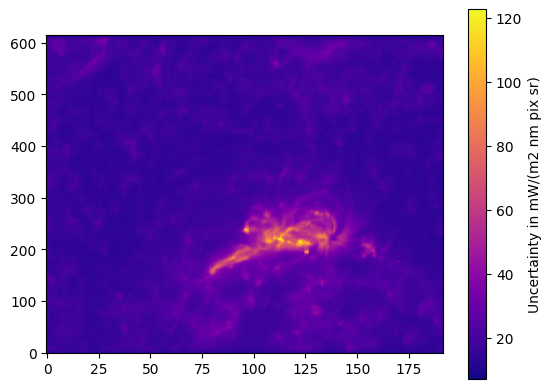

In [36]:
plt.imshow(sigma[19,:,:]*1e3, aspect=1/4, cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('Uncertainty in mW/(m2 nm pix sr)')

# What about a quick look of what we have?


In [38]:
#bindown for better SNR 
sigma = bindown(sigma,np.round(np.array(sigma.shape)/np.array([1,2,1])).astype(np.int32))
cube = bindown(data_cube,np.round(np.array(cube_sub.shape)/np.array([1,2,1])).astype(np.int32));

In [39]:
import tqdm
[nx,ny] = [cube.shape[1], cube.shape[2]]
radiances = np.zeros((nx,ny))
for i in tqdm.tqdm(range(0,nx)):
    for j in range(0,ny):
        data = np.max(cube[:, i, j]*(u.mW/u.m**2/u.sr/u.Angstrom)*2*2.5);
        #assuming a sigma = 1 A
        radiances[i,j] = (data.value/2)*np.sqrt(np.pi*2)*1;        

100%|████████████████████████████████████████████████████████████████████████████████| 308/308 [00:08<00:00, 34.53it/s]


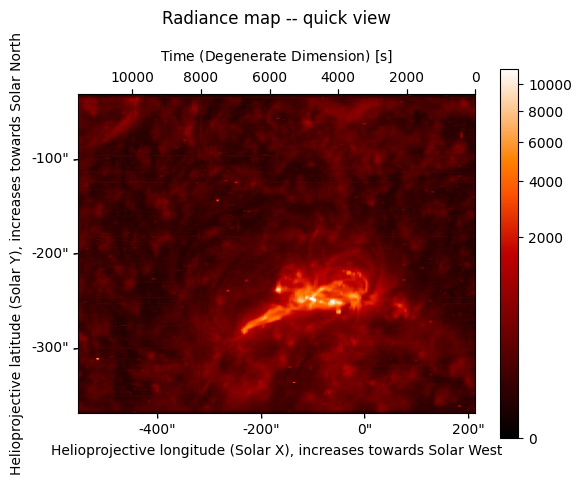

In [40]:
plt.subplot(111, projection=wcs, slices = ('x', 'y', 19))
plt.imshow(radiances, cmap='gist_heat', norm=mlt.colors.PowerNorm(0.35, vmin=0, vmax=np.nanquantile(radiances, 0.9999)), aspect = 1/2)
plt.title('Radiance map -- quick view\n\n\n'), plt.colorbar(), plt.show();

But careful! It might be an approximation for radiances and seem less noisy, but:
* cosmic rays!
* cannot access to real physical measurements, in particular:
    * cannot access to irradiance (area under the emission peak), and all the diagnostics that come with it
    * cannot retreive the line width (proxy for turbulence mesurement)
    * cannot access to doppler shift 

## Import the fitted radiance map...

In [ ]:
#without PSF correction 
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\radiance_NeVIII.json', 'rb') as fc:
    radNeVIII = pickle.load(fc)

In [41]:
#with PSF correction 
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\radiance_NeVIIIPSF.json', 'rb') as fc:
    ampsPSF = pickle.load(fc)

## ...and plot it!

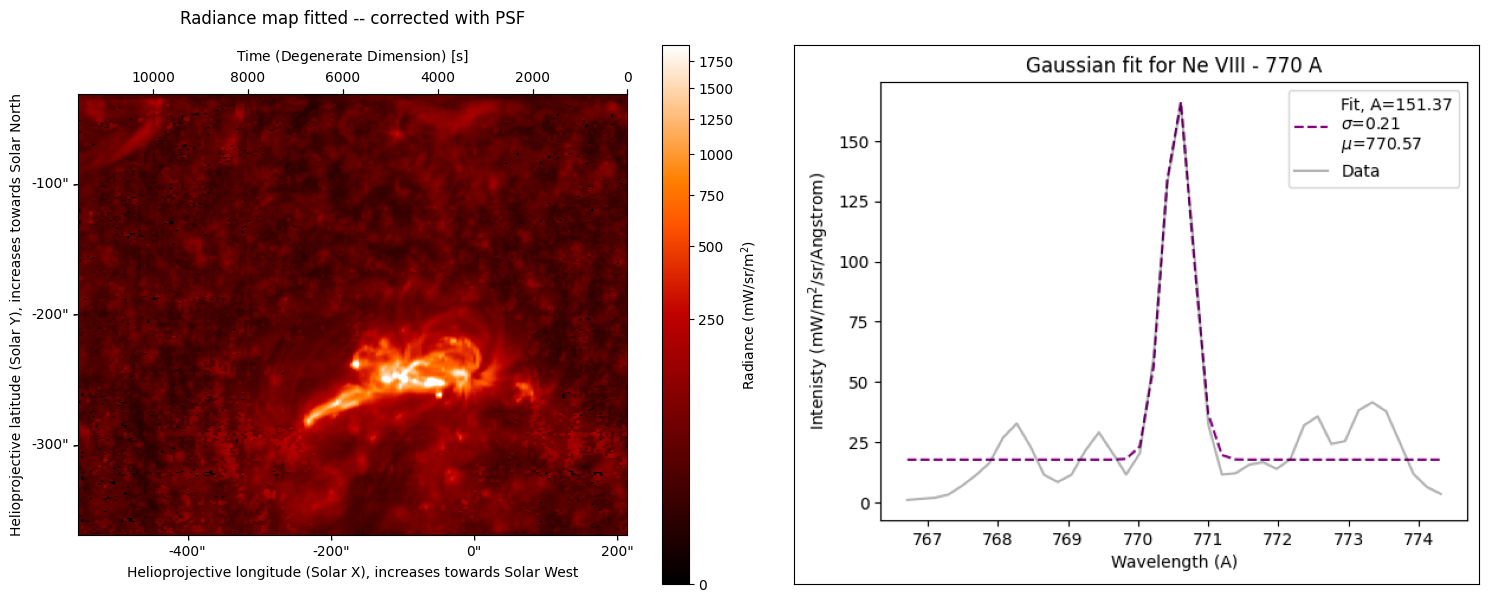

In [43]:
plt.figure(tight_layout=True, figsize=[15,6])
plt.subplot(121, projection=wcs, slices = ('x', 'y', 19))
plt.imshow((ampsPSF), cmap='gist_heat',norm=mlt.colors.PowerNorm(0.35, vmin=0, vmax=np.nanquantile(ampsPSF, 0.999)), aspect = 1/2)
plt.colorbar(label='Radiance (mW/sr/m$^2$)'), plt.title('Radiance map fitted -- corrected with PSF\n\n\n')
plt.subplot(122)
plt.imshow(mpimg.imread('images/gaussian_fit_Neviii.png'), origin='upper'),plt.xticks([], []),plt.yticks([], []), plt.show();

# Looking at the flux velocities
* Reveals important information on the mass and energy balance of the solar atmosphere, providing an important observational constraint to any models of the solar corona.
* Looking at flows on the surface (velocities +/- 40 km/s)

For context... *Slow Solar Wind Connection Science during Solar Orbiter's First Close Perihelion Passage, Yardley et al. 2023*
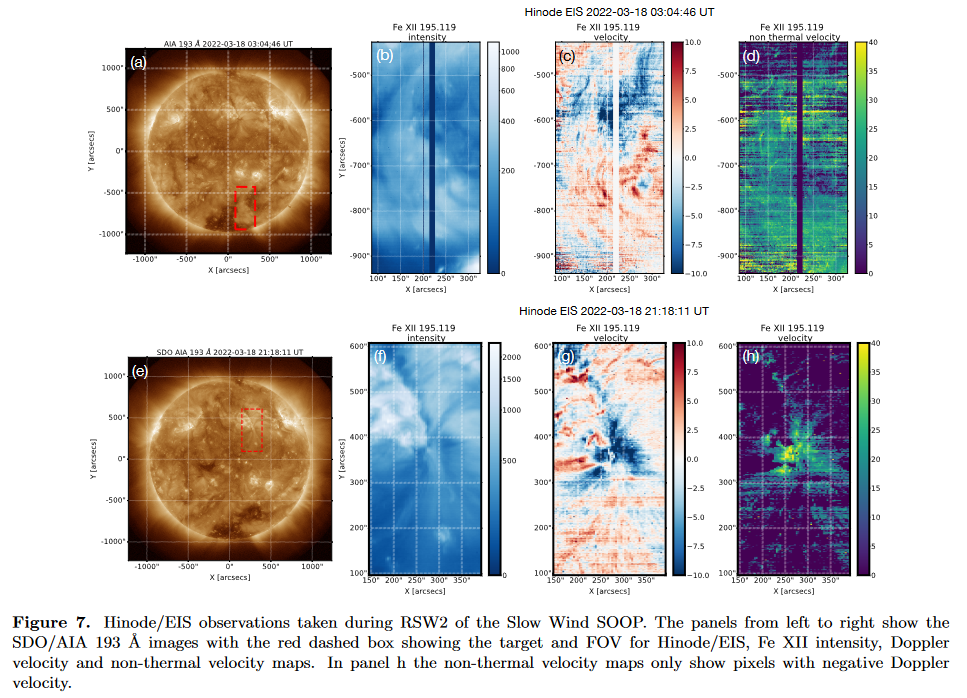

# Plot a closeup of the active region for flux velocities

In [44]:
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\dopp_NeVIIIPSF.json', 'rb') as fc:
    cenPSF = pickle.load(fc)

In [45]:
lambda0 = 770.065e-10
c=3e8
v = (c*(cenPSF*1e-10) / lambda0 )/ 1000

In [55]:
import matplotlib.patches as patches
center, radius = [(45,65), 35]
circle = patches.Circle(center, radius, edgecolor='black', facecolor='none')

In [53]:
#Update the zoomed in WCS
wcs = WCS(raster.meta.original_header)
wcs = wcs[0,:,115+100:730-400,75:160]

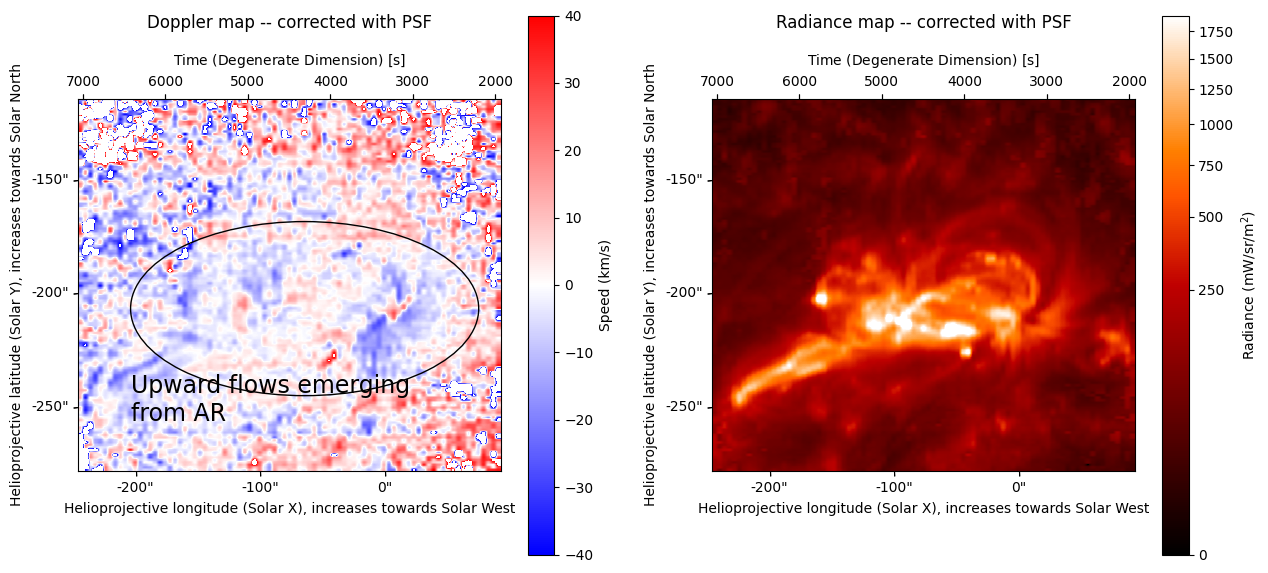

In [56]:
plt.figure(figsize=[15,7])
ax = plt.subplot(121, projection=wcs, slices = ('x', 'y', 19))
im = plt.imshow((v[50:200,75:160]-np.nanmedian(v[50:200,75:160])), cmap='bwr', vmin=-50, vmax=50, aspect = 1/2)
im.cmap.set_over('white'), im.cmap.set_under('white')
im.set_clim(-40,40)
plt.annotate('Upward flows emerging \nfrom AR', (10,20), fontsize=17)
plt.colorbar(label='Speed (km/s)')
plt.title('Doppler map -- corrected with PSF\n\n\n')
ax.add_patch(circle)

plt.subplot(122, projection=wcs, slices = ('x', 'y', 19))
plt.imshow((ampsPSF[50:200,75:160]), cmap='gist_heat',
           norm=mlt.colors.PowerNorm(0.35, vmin=0, vmax=np.nanquantile(ampsPSF, 0.999)), aspect = 1/2)
plt.colorbar(label='Radiance (mW/sr/m$^2$)')
plt.title('Radiance map -- corrected with PSF\n\n\n'), plt.show();

# Thank you for your attention! 

# Any questions are welcomed!

*These efforts at SwRI for Solar Orbiter SPICE are supported by NASA under GSFC subcontract #80GSFC20C0053 to
Southwest Research Institute.*

In [17]:
#spatial binning: saves time and increases SNR
def bindown(d,n):
    inds = np.ravel_multi_index(np.floor((np.indices(d.shape).T*n/np.array(d.shape))).T.astype(np.uint32),n)
    return np.bincount(inds.flatten(),weights=d.flatten(),minlength=np.prod(n)).reshape(n) 

In [18]:
#Define a function to subtract the background noise
def subtract_min_cube(cube):
    cube = np.nan_to_num(cube)
    det_plane_min = np.nanmin(cube,axis=2)
    print(det_plane_min)
    for i in range(0,cube.shape[2]): 
        cube[:,:,i] -= det_plane_min
    return cube

In [21]:
import tqdm
from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D
from astropy.modeling import models, fitting
from specutils.fitting import estimate_line_parameters
from astropy.nddata import StdDevUncertainty
from spice_uncertainties import spice_error
from astropy.io import fits

# Choose the key to fit
key = 'Ne VIII 770(Merged)'
cube = data_cube
cube = np.nan_to_num(cube) 

#Computing uncertainties
with fits.open(file) as hdulist:  # specify file name here
    hdu = hdulist[3];               # specify HDU index here
    av_constant_noise_level, sigma = spice_error(hdu, verbose=True)
    sigma = sigma['Total'][0,:,115:730,:].value/10  #to Angstrom

#Get the array of wavelengths
waves = wavelengths  

#Apply the function
cube_sub = subtract_min_cube(cube)
sigma = bindown(sigma,np.round(np.array(sigma.shape)/np.array([1,2,1])).astype(np.int32)) 
cube_sub = bindown(cube,np.round(np.array(cube.shape)/np.array([1,2,1])).astype(np.int32))

W / (m2 nm sr)
Getting observation parameters from Ne VIII 770 (Merged)

Slit: 4.0 arcsec
Bin: (2, 1)
Exposure time: 60.0 s
Window width: 40.0 pix
Average wavelength: 77.051337 nm
RADCAL: 2482.40730148 ct m2 nm sr / W
        
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 5.697604  6.5920873 6.4009323]
 ...
 [7.1853256 7.2423773 7.082288  ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]] mW / (Angstrom m2 sr)


In [45]:
waves.value

array([766.710207, 766.905241, 767.100275, 767.295309, 767.490343,
       767.685377, 767.880411, 768.075445, 768.270479, 768.465513,
       768.660547, 768.855581, 769.050615, 769.245649, 769.440683,
       769.635717, 769.830751, 770.025785, 770.220819, 770.415853,
       770.610887, 770.805921, 771.000955, 771.195989, 771.391023,
       771.586057, 771.781091, 771.976125, 772.171159, 772.366193,
       772.561227, 772.756261, 772.951295, 773.146329, 773.341363,
       773.536397, 773.731431, 773.926465, 774.121499, 774.316533])

In [ ]:
[nx, ny] = cube_sub.shape[1:3]
# Set a reference value for the mean wavelegnth of the emission peak
dopp1= 770.4

# Initialize arrays
nbrIterConv = np.zeros([nx,ny])
rss, rss1, rss2, rss3 = np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny])
amps1, cen1, err1, sig1 = np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny])


for i in tqdm.tqdm(range(0,nx)):
    for j in range(0,ny):
        data = np.nan_to_num(cube_sub[:, i, j]).to(u.mW/u.m**2/u.sr/u.Angstrom)*2*2.5 #burn in and spectral binning
        errs = np.nan_to_num(sigma[:, i, j])*1e3 #to mW instead of W
      
        # Create a spectrum object to do the line fitting
        spec = Spectrum1D(flux = data, spectral_axis = waves, uncertainty=StdDevUncertainty(errs))#, mask=mask)
    
        # Create the model : one constant to fit the continuum and one gaussian curve, defining boundaries on the parameters
        c_init = models.Const1D(amplitude = np.nanmean(data)/20, bounds={'amplitude':[np.min(data),np.max(data)]})
        g_init = estimate_line_parameters(spec, models.Gaussian1D(bounds = {'stddev':[0.3,3], 'mean':[dopp1-1, dopp1+1]}))
        
        # Do the line fitting   
        g_fit = fit_lines(spec, g_init +  c_init)
        y_fit = g_fit(waves)

        # Store the results
        amps1[i][j] = (g_fit.amplitude_0.value/2)*np.sqrt(np.pi*2)*g_fit.stddev_0.value
        cen1[i][j] = dopp1  - g_fit.mean_0.value
        rss[i][j] = np.abs(np.mean(g_fit.meta['fit_info']['fvec']))
        nbrIterConv[i][j] = g_fit.meta['fit_info']['nfev']

In [ ]:
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\radiance_NeVIII.json', 'wb') as fc:
    pickle.dump(amps1, fc)

In [ ]:
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\n_iter_NeVIII.json', 'wb') as fi:
    pickle.dump(nbrIterConv, fi)

In [ ]:
## Line fitting with PSF corrected 
cube = data_cube_corr
cube = np.nan_to_num(cube) 

cube_sub = bindown(cube,np.round(np.array(cube.shape)/np.array([1,2,1])).astype(np.int32))
[nx, ny] = cube_sub.shape[1:3]
# Set a reference value for the mean wavelegnth of the emission peak
dopp1= 770.4

# Initialize arrays
nbrIterConvPSF = np.zeros([nx,ny])

ampsPSF, cenPSF, errPSF, sigPSF, rssPSF = np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny]), np.zeros([nx,ny])


for i in tqdm.tqdm(range(0,nx)):
    for j in range(0,ny):
        data = np.nan_to_num(cube_sub[:, i, j])*(u.mW/u.m**2/u.sr/u.Angstrom)*2*2.5 #burn in and spectral binning
        errs = np.nan_to_num(sigma[:, i, j])*1e3 #to mW instead of W
      
        # Create a spectrum object to do the line fitting
        spec = Spectrum1D(flux = data, spectral_axis = waves, uncertainty=StdDevUncertainty(errs))#, mask=mask)
    
        # Create the model : one constant to fit the continuum and one gaussian curve, defining boundaries on the parameters
        c_init = models.Const1D(amplitude = np.nanmean(data)/20, bounds={'amplitude':[np.min(data),np.max(data)]})
        g_init = estimate_line_parameters(spec, models.Gaussian1D(bounds = {'stddev':[0.1,3], 'mean':[dopp1-2, dopp1+2]}))
        
        # Do the line fitting   
        g_fit = fit_lines(spec, g_init +  c_init)
        y_fit = g_fit(waves)
        if ((i+1)%(j+1)==4):
            plt.figure()
            plt.plot(waves.value, y_fit, 
                     label='Fit, A='+str("{:.2f}".format(g_fit.amplitude_0.value))+ '\n$\sigma$='+str("{:.2f}".format(g_fit.stddev_0.value))+'\n$\mu$='+str("{:.2f}".format(g_fit.mean_0.value)), 
                     color='purple', linestyle='--')
            plt.plot(waves.value, data.value, label='Data', color='k', alpha=0.3)
            plt.xlabel('Wavelength (A)'), plt.ylabel('Intenisty (mW/m$^2$/sr/Angstrom)'), plt.title('Gaussian fit for Ne VIII - 770 A')
            plt.legend(), plt.show();
        # Store the results
        ampsPSF[i][j] = (g_fit.amplitude_0.value/2)*np.sqrt(np.pi*2)*g_fit.stddev_0.value
        cenPSF[i][j] = dopp1  - g_fit.mean_0.value
        rssPSF[i][j] = np.abs(np.mean(g_fit.meta['fit_info']['fvec']))
        nbrIterConvPSF[i][j] = g_fit.meta['fit_info']['nfev']

In [ ]:
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\radiance_NeVIIIPSF.json', 'wb') as fc:
    pickle.dump(ampsPSF, fc)

In [ ]:
with open('C:\\Users\\tania\\OneDrive\\Documents\\US\\2023\\NASA GSFC oct 2023\\dopp_NeVIIIPSF.json', 'wb') as fc:
    pickle.dump(cenPSF, fc)